## OIS Bootstrap

The goal of this notebook is to bootstrap an OIS Zero Curve from Swap par quotes. Afterwards, I want to validate the created curve by manually creating an OIS Swap, use the bootstrapped curve to price it and to hit the par quote which I have put in in the first place. I.e. I want to perform a round trip pricing validation of my bootstrapped curve.

In [1]:
# initiating

import QuantLib as ql

today = ql.Date(10, ql.May, 2019)
ql.Settings.instance().evaluationDate = today

In [2]:
# Par Quotes used as input

swap_quotes = {ql.Period(2, ql.Weeks): ql.SimpleQuote(-0.36503/100),
               ql.Period(1, ql.Months): ql.SimpleQuote(-0.3650/100),
               ql.Period(3, ql.Months): ql.SimpleQuote(-0.36521/100),
               ql.Period(6, ql.Months): ql.SimpleQuote(-0.36754/100),
               ql.Period(1, ql.Years): ql.SimpleQuote(-0.37488/100),
               ql.Period(3, ql.Years): ql.SimpleQuote(-0.31511/100),
               ql.Period(10, ql.Years): ql.SimpleQuote(0.28879/100),
               ql.Period(15, ql.Years): ql.SimpleQuote(0.62908/100),
               ql.Period(20, ql.Years): ql.SimpleQuote(0.82255/100),
               ql.Period(30, ql.Years): ql.SimpleQuote(0.92238/100)}

As described in the Quantlib Cookbook we can use the OISRateHelper to automatically create a bunch of OvernightIndexedSwaps from these quotes. To my understanding most properties (fixing rolling etc) of these swaps are implied by the used index - in this case the EONIA index.

In [3]:
eonia_index = ql.Eonia()

helpers = []
for tenor, quote in swap_quotes.items():
    helpers.append(ql.OISRateHelper(0, tenor, ql.QuoteHandle(quote), eonia_index))

Again as described in the Cookbook we are using the PiecewiseLogCubicDiscount method to bootstrap and interpolate a curve out of the swaps created by the OISRateHelper. Unfortunately, PiecwiseLogCubicDiscount does not appear to exist as a class in C++ QuantLib. It is probably a special case of some other class but I'm therefore struggling to find documentation on its properties and methods.

In [4]:
eonia_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual360())
eonia_curve.enableExtrapolation()

After this, the object can create nice looking curves as can be seen when plotting a Zero and 1D Forward Curve from it:

In [5]:
end= today+ql.Period(30, ql.Years)
dates= [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1)]
forward_rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate() for d in dates]
zero_rates = [eonia_curve.zeroRate(d, ql.Actual360(), ql.Simple).rate() for d in dates]

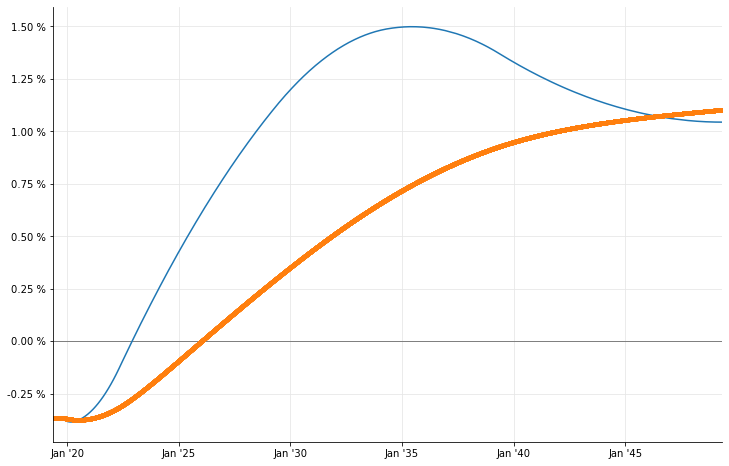

In [6]:
from quantlibpythoncookbook_extras import utils

_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(forward_rates, '-')], format_rates=True)
utils.plot_curve(ax, dates, [(zero_rates, '.')], format_rates=True)

Next, I want to manually create an OvernightIndexedSwap that matches one that QuantLib has 'automatically' created to build the curve. I'm choosing the 1 Year OIS Swap - the Swap on position 4 of the helper array.

In [7]:
reference_swap = helpers[4].swap()
reference_fixed_leg = reference_swap.fixedLeg()
print(reference_fixed_leg[0].date())
reference_overnight_leg = reference_swap.overnightLeg()
print(reference_overnight_leg[0].date())
testType = reference_swap.type()

May 11th, 2020
May 11th, 2020


I can ask the swap for its fair rate and see that it is the same as the input quote. I'm not sure where the pricing engine is coming from that this swap is using to be honest.

In [8]:
print(reference_swap.fairRate())
print(swap_quotes[ql.Period(1, ql.Years)].value())

-0.0037487999999999333
-0.0037488


Next, I'm creating an equivalent OIS manually.

In [9]:
nominal = 100.0
fixedRate = 0.01
dc = ql.Actual360()
type = ql.OvernightIndexedSwap.Payer
test_schedule = ql.Schedule (today, ql.Date(11, ql.May, 2020), ql.Period(1, ql.Days), ql.TARGET(), ql.ModifiedFollowing, ql.ModifiedFollowing, ql.DateGeneration.Forward, False)
test_ois = ql.OvernightIndexedSwap(type, nominal, test_schedule, fixedRate, dc, eonia_index)

Now, to calculate this swap's par rate for comparison, I do need to attach a pricing engine to this trade. Here I'am currently getting stuck. I can't figure out how to create a pricing engine from my PiecewiseLogCubicDiscount object.

In [10]:
pricing_engine = ql.DiscountingSwapEngine(ql.YieldTermStructureHandle(eonia_curve))
test_ois.setPricingEngine(pricing_engine)
test_ois.fairRate()


RuntimeError: 2nd leg: null term structure set to this instance of EoniaON Actual/360

Try to use this pricing engine on the original swap instead.

In [ ]:
reference_swap.setPricingEngine(pricing_engine)
reference_swap.fairRate()

PiecewiseLogCubicDiscount does not appear to be a YieldTermStructure and since it is also not documented I don't know how to extract a YieldTermStructure from it. Especially, I want to still keep the dependency of the curve to the original quotes to make it simple to calculate par sensitivities.

In [ ]:
dates, rates = zip(*eonia_curve.nodes())

dummy_TS=ql.DiscountCurve(dates, rates, ql.Actual360())
pricing_engine = ql.DiscountingSwapEngine(dummy_TS)